In [ ]:
# Standard Library Imports
import os
import sys
import timeit
from scipy.optimize import least_squares

# Optimize performance by setting environment variables
os.environ['OPENBLAS_NUM_THREADS'] = '1'
os.environ['OMP_NUM_THREADS'] = '1'
os.environ['KERAS_BACKEND'] = 'tensorflow'
from timeit import repeat

# Third-party Library Imports
import numpy as np
import pandas as pd
import tensorflow as tf
import arviz as az
import scipy.stats as stats
import matplotlib.pyplot as plt
from scipy.stats import gaussian_kde, multivariate_normal, uniform
from tensorflow.keras.models import load_model
from itertools import product
from numba import jit

# Local Module Imports
sys.path.append('./data/data_generation/')
import tinyDA as tda

from model import Model
# from utils import *

case = "MFDA1"  # "MFDA2", "MLDA", "MLDA2", "MFDA1, "FOM"

# MCMC Parameters
noise        = 0.01
noise_Str    = str(noise).replace('.', '_')
scaling      = 0.01
scale        = str(scaling).replace('.', '_')
scaling1     = 1
scaling2     = 1
scaling3     = 1
n_iter       = 1000
burnin       = 500
thin         = 1
sub          = 1

sub_sampling = [10,2]
n_train_samples = 64000

# Initialize Parameters
n_samples = 100
np.random.seed(1)
random_samples = np.random.randint(0, 10000, n_samples)
n_eig = 64
X_values = np.loadtxt('data/data/X_test_h1_100_01.csv', delimiter=',')
y_values = np.loadtxt('data/data/y_test_h1_100_01.csv', delimiter=',')

# Resolution Parameters for Different Solvers
resolutions = [(100, 100), (50, 50), (25, 25), (10, 10)]
field_mean, field_stdev, lamb_cov, mkl = 1, 1, 0.1, 64 

# Instantiate Models for Different Resolutions
solver_h1 = Model(resolutions[0], field_mean, field_stdev, mkl, lamb_cov)
solver_h2 = Model(resolutions[1], field_mean, field_stdev, mkl, lamb_cov)
solver_h3 = Model(resolutions[2], field_mean, field_stdev, mkl, lamb_cov)
solver_h4 = Model(resolutions[3], field_mean, field_stdev, mkl, lamb_cov)

def setup_random_process(solver_high, solver_low):
    """
    Synchronize the random processes between the higher and lower fidelity models
    by matching transmissivity fields across different resolutions.
    """
    coords_high = solver_high.solver.mesh.coordinates()
    coords_low = solver_low.solver.mesh.coordinates()
    
    structured_high = np.array(coords_high).view([('', coords_high.dtype)] * coords_high.shape[1])
    structured_low = np.array(coords_low).view([('', coords_low.dtype)] * coords_low.shape[1])
    
    bool_mask = np.in1d(structured_high, structured_low)
    solver_low.random_process.eigenvalues = solver_high.random_process.eigenvalues
    solver_low.random_process.eigenvectors = solver_high.random_process.eigenvectors[bool_mask]  

# Setup random processes between solvers
setup_random_process(solver_h1, solver_h2)
setup_random_process(solver_h1, solver_h3)
setup_random_process(solver_h1, solver_h4)

# Define Points for Data Extraction
x_data = y_data = np.array([0.1, 0.3, 0.5, 0.7, 0.9])
datapoints = np.array(list(product(x_data, y_data)))

# Solver Data Functions
def solver_h1_data(x):
    solver_h1.solve(x)
    return solver_h1.get_data(datapoints)
def solver_h2_data(x):
    solver_h2.solve(x) 
    return solver_h2.get_data(datapoints)
def solver_h3_data(x): 
    solver_h3.solve(x)
    return solver_h3.get_data(datapoints)
def solver_h4_data(x): 
    solver_h4.solve(x)
    return solver_h4.get_data(datapoints)

def model_HF(input): return solver_h1_data(input).flatten()
def model_LF1(input): return solver_h2_data(input).flatten()
def model_LF2(input): return solver_h3_data(input).flatten()
def model_LF3(input): return solver_h4_data(input).flatten()

# Model Definitions for Different Cases
if case == "MFDA2":
    # Load Models for Low- and Multi-fidelity Predictions
        # Load Models for Low- and Multi-fidelity Predictions
    model_nn = load_model(f'models/single_fidelity_100/resolution_10/samples_{n_train_samples}/model_fold_1.keras')
    models_1 = load_model(f'models/multi_fidelity_100_2step/input_10/samples_{n_train_samples}/model_fold_1.keras')
    models_2 = load_model(f'models/multi_fidelity_100_2step/input_10_25/samples_{n_train_samples}/model_fold_1.keras')
    models_3 = load_model(f'models/multi_fidelity_100_2step/input_10_25_50/samples_{n_train_samples}/model_fold_1.keras')
    
    @tf.function(jit_compile=True) 
    def model_mf1(input1, input2):
        input1    = tf.reshape(input1, (1, 64))
        input2    = tf.reshape(input2, (1, 25))
        return models_1([input1,input2], training=False)[0]
    
    @tf.function(jit_compile=True) 
    def model_mf2(input1, input2, input3):
        input1    = tf.reshape(input1, (1, 64))
        input2    = tf.reshape(input2, (1, 25))
        input3    = tf.reshape(input3, (1, 25))
        return models_2([input1,input2,input3], training=False)[0]
    
    @tf.function(jit_compile=True) 
    def model_mf3(input1, input2, input3, input4):
        input1    = tf.reshape(input1, (1, 64))
        input2    = tf.reshape(input2, (1, 25))
        input3    = tf.reshape(input3, (1, 25))
        input4    = tf.reshape(input4, (1, 25))
        return models_3([input1,input2,input3,input4], training=False)[0]
    
    # def model_1(input):
    #     coarse_data1 = tf.constant(solver_h4_data(input), dtype=tf.float32)
    #     return model_mf1(input, coarse_data1).numpy().flatten()
    @tf.function(jit_compile=True) 
    def model_cc(input):
        inputx = tf.reshape(input, (1, 64))
        return model_nn(inputx, training=False)[0]
    
    def model_1(input):
        coarse_data1 = model_cc(input)
        return model_mf1(input, coarse_data1).numpy().flatten()
    
    def model_2(input):
        coarse_data1 = model_cc(input)
        coarse_data2 = tf.constant(solver_h3_data(input), dtype=tf.float32)
        return model_mf2(input, coarse_data2, coarse_data1).numpy().flatten()

    def model_3(input):
        coarse_data2 = tf.constant(solver_h3_data(input), dtype=tf.float32)
        coarse_data3 = tf.constant(solver_h2_data(input), dtype=tf.float32)
        coarse_data1 = model_cc(input)
        return model_mf3(input, coarse_data3, coarse_data2,coarse_data1).numpy().flatten()
    
    def model_HF(input): return solver_h1_data(input).flatten()
    

elif case == "MFDA1":
    # Load Models for Low- and Multi-fidelity Predictions
    models_1 = load_model(f'models/multi_fidelity_100/input_10/samples_{n_train_samples}/model_fold_1.keras')
    models_2 = load_model(f'models/multi_fidelity_100/input_10_25/samples_{n_train_samples}/model_fold_1.keras')
    models_3 = load_model(f'models/multi_fidelity_100/input_10_25_50/samples_{n_train_samples}/model_fold_1.keras')

    @tf.function(jit_compile=True) 
    def model_mf1(input1, input2):
        input1    = tf.reshape(input1, (1, 64))
        input2    = tf.reshape(input2, (1, 25))
        return models_1([input1,input2], training=False)[0]
    
    @tf.function(jit_compile=True) 
    def model_mf2(input1, input2, input3):
        input1    = tf.reshape(input1, (1, 64))
        input2    = tf.reshape(input2, (1, 25))
        input3    = tf.reshape(input3, (1, 25))
        return models_2([input1,input2,input3], training=False)[0]
    
    @tf.function(jit_compile=True) 
    def model_mf3(input1, input2, input3, input4):
        input1    = tf.reshape(input1, (1, 64))
        input2    = tf.reshape(input2, (1, 25))
        input3    = tf.reshape(input3, (1, 25))
        input4    = tf.reshape(input4, (1, 25))
        return models_3([input1,input2,input3,input4], training=False)[0]
    
    # def model_1(input):
    #     coarse_data1 = tf.constant(solver_h4_data(input), dtype=tf.float32)
    #     return model_mf1(input, coarse_data1).numpy().flatten()
    
    def model_1(input):
        coarse_data1 = tf.constant(solver_h4_data(input), dtype=tf.float32)
        return model_mf1(input, coarse_data1).numpy().flatten()
    
    def model_2(input):
        coarse_data1 = tf.constant(solver_h4_data(input), dtype=tf.float32)
        coarse_data2 = tf.constant(solver_h3_data(input), dtype=tf.float32)
        return model_mf2(input, coarse_data2, coarse_data1).numpy().flatten()

    def model_3(input):
        coarse_data1 = tf.constant(solver_h4_data(input), dtype=tf.float32)
        coarse_data2 = tf.constant(solver_h3_data(input), dtype=tf.float32)
        coarse_data3 = tf.constant(solver_h2_data(input), dtype=tf.float32)
        return model_mf3(input, coarse_data3, coarse_data2,coarse_data1).numpy().flatten()
    
    def model_HF(input): return solver_h1_data(input).flatten()
    
elif case == "MLDA1":
    
    model_1 = model_LF2
    model_2 = model_LF1
    model_3 = model_HF
    
elif case == "MLDA2":
    
    model_1 = model_LF3
    model_2 = model_LF2
    model_3 = model_LF1





: 

In [6]:
def plot2(solver_h1, limits = [0,0], transform_field = False):
    
    # This method plots both the random firld and the solution.
    
    # First, contruct a random field, given the field parameters.
    if transform_field:
        random_field = np.exp(solver_h1.field_mean + solver_h1.field_stdev*solver_h1.random_process.random_field)
    else:
        random_field = solver_h1.field_mean + solver_h1.field_stdev*solver_h1.random_process.random_field
    
    # Set contour levels.
    if any(limits):
        contour_levels_field = np.linspace(limits[0], limits[1], 100)
    else:
        contour_levels_field = np.linspace(min(random_field), max(random_field), 100)
    
    # Then extract the solution from every node in the solver.
    solution = solver_h1.get_solution()
            
    # Set the contour levels.
    contour_levels_solution = np.linspace(min(solution), max(solution), 100)
    
    # Plot field and solution.
    fig, axes = plt.subplots(nrows=1, ncols=1, figsize = (10, 9))
    
    axes.tick_params(labelsize=16)
    field = axes.tricontourf(solver_h1.x, 
                                solver_h1.y, 
                                random_field, 
                                levels = contour_levels_field, 
                                cmap = 'jet');  

In [ ]:
n_iter       = 26000
burnin       = 6000
noise= 0.01
sub_sampling = [10,2]
thin = 5


# Prior and Proposal Distributions
x_distribution = stats.multivariate_normal(mean=np.zeros(64), cov=np.eye(64))
Times, Time_ESS, ESS, samples_tot, ERR = [], [], [], [], []

# Sampling for Each Random Sample
for i, sample in enumerate([5396], start=1):
    print(f'Sample = {sample}')
    x_true = X_values[sample]
    y_true = y_values[sample]
    y_observed = y_true + np.random.normal(scale=noise, size=y_true.shape[0])
        
    # def ls(x):
    #     return (y_true-model_HF(x))

    # res = least_squares(ls,np.zeros_like((x_true)), jac='3-point')
    # covariance = np.linalg.pinv(res.jac.T @ res.jac)
    # covariance *= 1/np.max(np.abs(covariance))
    # print(covariance[1:5,1:5])

    # Likelihood Distributions
    cov_likelihood = noise**2 * np.eye(25)
    y_distribution_1 = tda.AdaptiveGaussianLogLike(y_observed, cov_likelihood*scaling1)
    y_distribution_2 = tda.AdaptiveGaussianLogLike(y_observed, cov_likelihood*scaling2)
    y_distribution_3 = tda.AdaptiveGaussianLogLike(y_observed, cov_likelihood*scaling3)
    y_distribution_fine = tda.GaussianLogLike(y_observed, cov_likelihood)
    my_proposal = tda.GaussianRandomWalk(C=covariance,scaling=scaling, adaptive=True, gamma=1.1, period=100)
    # Initialize Posteriors
    my_posteriors = [
        tda.Posterior(x_distribution, y_distribution_1, model_1),
        tda.Posterior(x_distribution, y_distribution_2, model_2),
        tda.Posterior(x_distribution, y_distribution_3, model_3)
    ] if case != "FOM" else tda.Posterior(x_distribution, y_distribution_fine, model_HF)

    # Run MCMC Sampling
    start_time = timeit.default_timer()
    samples = tda.sample(my_posteriors, my_proposal, iterations=n_iter, n_chains=1,
                            initial_parameters=res.x, subchain_length=sub_sampling,
                            adaptive_error_model='state-independent',store_coarse_chain=False)
    elapsed_time = timeit.default_timer() - start_time

    # Effective Sample Size (ESS)
    idata = tda.to_inference_data(samples, level=2).sel(draw=slice(burnin, None, thin), groups="posterior")
    ess = az.ess(idata)
    mean_ess = np.mean([ess.data_vars[f'x{j}'].values for j in range(64)])

    # Store Results
    Times.append(elapsed_time)
    ESS.append(mean_ess)
    Time_ESS.append(elapsed_time / mean_ess)
    post = idata.posterior
    val=post.mean().to_array()
    err=(np.mean(np.sqrt((x_true-val)**2)))
    ERR.append(err)
    print(f'Time: {elapsed_time:.2f}, ESS: {mean_ess:.2f}, Time/ESS: {elapsed_time / mean_ess:.2f}, Err: {err:.3f} ({i}/{n_samples})')
    
    x = np.zeros((64,1))
    x[0]=np.mean(idata.posterior.x0.values)
    x[1]=np.mean(idata.posterior.x1.values)
    x[2]=np.mean(idata.posterior.x2.values)
    x[3]=np.mean(idata.posterior.x3.values)
    x[4]=np.mean(idata.posterior.x4.values)
    x[5]=np.mean(idata.posterior.x5.values)     
    x[6]=np.mean(idata.posterior.x6.values)
    x[7]=np.mean(idata.posterior.x7.values)
    x[8]=np.mean(idata.posterior.x8.values)
    x[9]=np.mean(idata.posterior.x9.values)
    x[10]=np.mean(idata.posterior.x10.values)
    x[11]=np.mean(idata.posterior.x11.values)
    x[12]=np.mean(idata.posterior.x12.values)
    x[13]=np.mean(idata.posterior.x13.values)
    x[14]=np.mean(idata.posterior.x14.values)
    x[15]=np.mean(idata.posterior.x15.values)
    x[16]=np.mean(idata.posterior.x16.values)
    x[17]=np.mean(idata.posterior.x17.values)
    x[18]=np.mean(idata.posterior.x18.values)   
    x[19]=np.mean(idata.posterior.x19.values)
    x[20]=np.mean(idata.posterior.x20.values)
    x[21]=np.mean(idata.posterior.x21.values)
    x[22]=np.mean(idata.posterior.x22.values)
    x[23]=np.mean(idata.posterior.x23.values)
    x[24]=np.mean(idata.posterior.x24.values)
    x[25]=np.mean(idata.posterior.x25.values)
    x[26]=np.mean(idata.posterior.x26.values)
    x[27]=np.mean(idata.posterior.x27.values)
    x[28]=np.mean(idata.posterior.x28.values)
    x[29]=np.mean(idata.posterior.x29.values)
    x[30]=np.mean(idata.posterior.x30.values)
    x[31]=np.mean(idata.posterior.x31.values)
    x[32]=np.mean(idata.posterior.x32.values)
    x[33]=np.mean(idata.posterior.x33.values)
    x[34]=np.mean(idata.posterior.x34.values)
    x[35]=np.mean(idata.posterior.x35.values)
    x[36]=np.mean(idata.posterior.x36.values)
    x[37]=np.mean(idata.posterior.x37.values)
    x[38]=np.mean(idata.posterior.x38.values)
    x[39]=np.mean(idata.posterior.x39.values)
    x[40]=np.mean(idata.posterior.x40.values)
    x[41]=np.mean(idata.posterior.x41.values)
    x[42]=np.mean(idata.posterior.x42.values)
    x[43]=np.mean(idata.posterior.x43.values)
    x[44]=np.mean(idata.posterior.x44.values)
    x[45]=np.mean(idata.posterior.x45.values)
    x[46]=np.mean(idata.posterior.x46.values)
    x[47]=np.mean(idata.posterior.x47.values)
    x[48]=np.mean(idata.posterior.x48.values)
    x[49]=np.mean(idata.posterior.x49.values)
    x[50]=np.mean(idata.posterior.x50.values)
    x[51]=np.mean(idata.posterior.x51.values)
    x[52]=np.mean(idata.posterior.x52.values)
    x[53]=np.mean(idata.posterior.x53.values)
    x[54]=np.mean(idata.posterior.x54.values)   
    x[55]=np.mean(idata.posterior.x55.values)
    x[56]=np.mean(idata.posterior.x56.values)
    x[57]=np.mean(idata.posterior.x57.values)
    x[58]=np.mean(idata.posterior.x58.values)
    x[59]=np.mean(idata.posterior.x59.values)
    x[60]=np.mean(idata.posterior.x60.values)
    x[61]=np.mean(idata.posterior.x61.values)
    x[62]=np.mean(idata.posterior.x62.values)
    x[63]=np.mean(idata.posterior.x63.values)
    x = x.flatten()
    
    solver_h1.solve(x_true)
    plot2(solver_h1)
    
    plt.show()

    solver_h1.solve(res.x)
    plot2(solver_h1)

    plt.show()

Sample = 5396
Sampling chain 1/1


Running chain, α = 0.88:  83%|████████▎ | 21509/26000 [1:16:15<15:37,  4.79it/s]

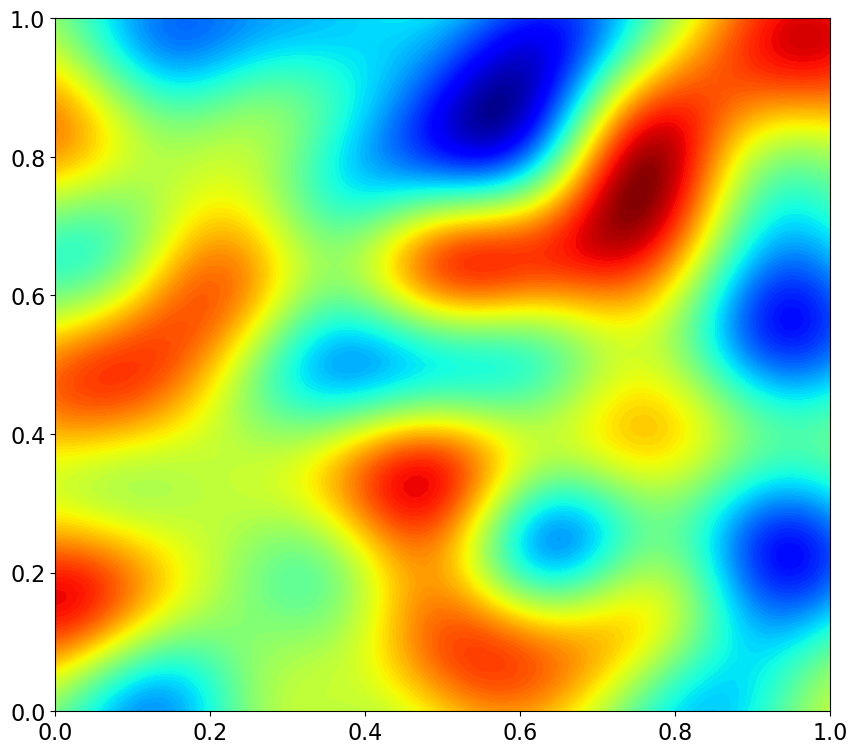

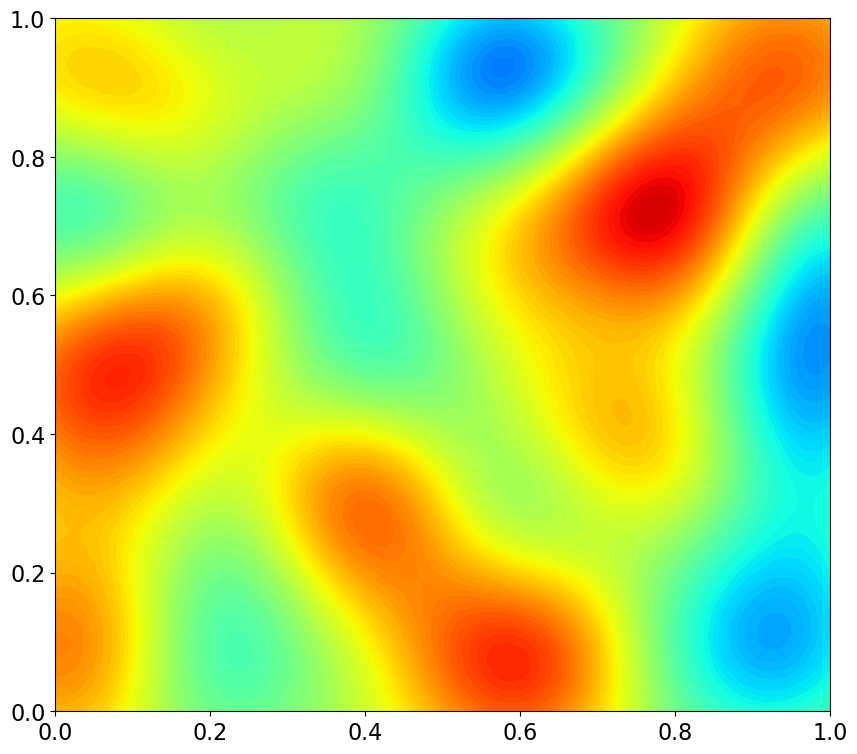

In [17]:
solver_h1.solve(x_true)
plot2(solver_h1,limits=[-1.75,2.95])
plt.savefig('figures/true.png', dpi=300, bbox_inches='tight')
plt.show()



solver_h1.solve(x)
plot2(solver_h1,limits=[-1.75,2.95])
plt.savefig('figures/mfda2.png', dpi=300, bbox_inches='tight')
